In [1]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

from dustmaps.sfd import SFDQuery
from helpers import get_ext

/Users/adrian/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
g = GaiaData('../data/data-joined.fits')
c = g.get_skycoord(distance=False)
mag_c = c.transform_to(gc.MagellanicStream)

cluster_c = coord.SkyCoord(ra=179.5*u.deg,
                           dec=-28.8*u.deg)

In [3]:
ptstyle = dict(marker='.', ls='none', alpha=0.2, color='k')

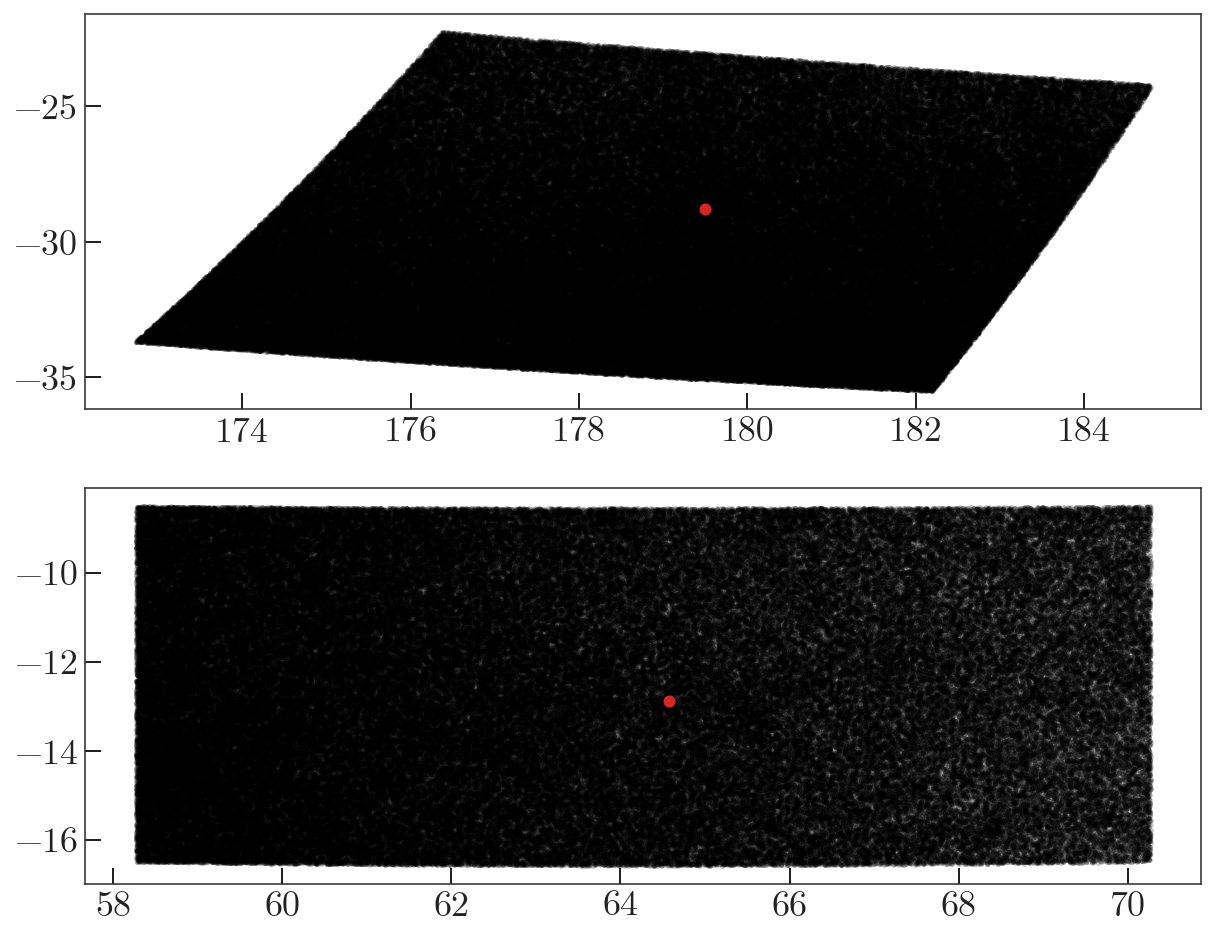

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(g.ra, g.dec, **ptstyle)
axes[0].scatter(cluster_c.ra, cluster_c.dec, marker='o', color='tab:red', zorder=100)

axes[1].plot(mag_c.L.degree, mag_c.B.degree, **ptstyle)
axes[1].scatter(cluster_c.transform_to(gc.MagellanicStream).L, 
                cluster_c.transform_to(gc.MagellanicStream).B,
                marker='o', color='tab:red', zorder=100)

In [5]:
control_mask = ( ((mag_c.L < 70*u.deg) & (mag_c.L > 69*u.deg)) |
                 ((mag_c.L < 60*u.deg) & (mag_c.L > 59*u.deg)) )
control_area = 8*u.deg * 2*u.deg

### Dust-correct Gaia colors:

In [6]:
sfd = SFDQuery()
ebv = sfd.query(c)

In [7]:
Agaia = np.vstack(get_ext(g.phot_g_mean_mag.value,
                          g.phot_bp_mean_mag.value,
                          g.phot_rp_mean_mag.value,
                          ebv)).T

In [8]:
G0 = g.phot_g_mean_mag.value - Agaia[:, 0]
BP0 = g.phot_bp_mean_mag.value - Agaia[:, 1]
RP0 = g.phot_rp_mean_mag.value - Agaia[:, 2]
bprp0 = BP0 - RP0

In [9]:
# same area as control field
cl_rough_mask = c.separation(cluster_c) < 2.26*u.deg
cl_area = np.pi * (2.26*u.deg)**2

cl_rough_mask.sum(), control_mask.sum(), control_area, cl_area

(49067, 50553, <Quantity 16. deg2>, <Quantity 16.04599864 deg2>)

In [10]:
bins = (np.arange(-1, 2+1e-3, 0.04),
        np.arange(11, 21+1e-3, 0.08))

H, xe_cmd, ye_cmd = np.histogram2d(bprp0[control_mask], G0[control_mask],
                                   bins=bins)
H_bg = H.T

H, xe, ye = np.histogram2d(bprp0[cl_rough_mask], G0[cl_rough_mask],
                           bins=bins)
H_fg = H.T

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


In [11]:
bins = np.arange(-5, 5+1e-3, 0.2)

H, xe_pm, ye_pm = np.histogram2d(g.pmra[control_mask], g.pmdec[control_mask],
                                 bins=bins)
H_bg_pm = H.T

In [76]:
dark_ptstyle = dict(marker='.', ls='none', alpha=0.75, color='k', rasterized=True)
pcolor_style = dict(cmap='copper', rasterized=True, linewidth=0)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


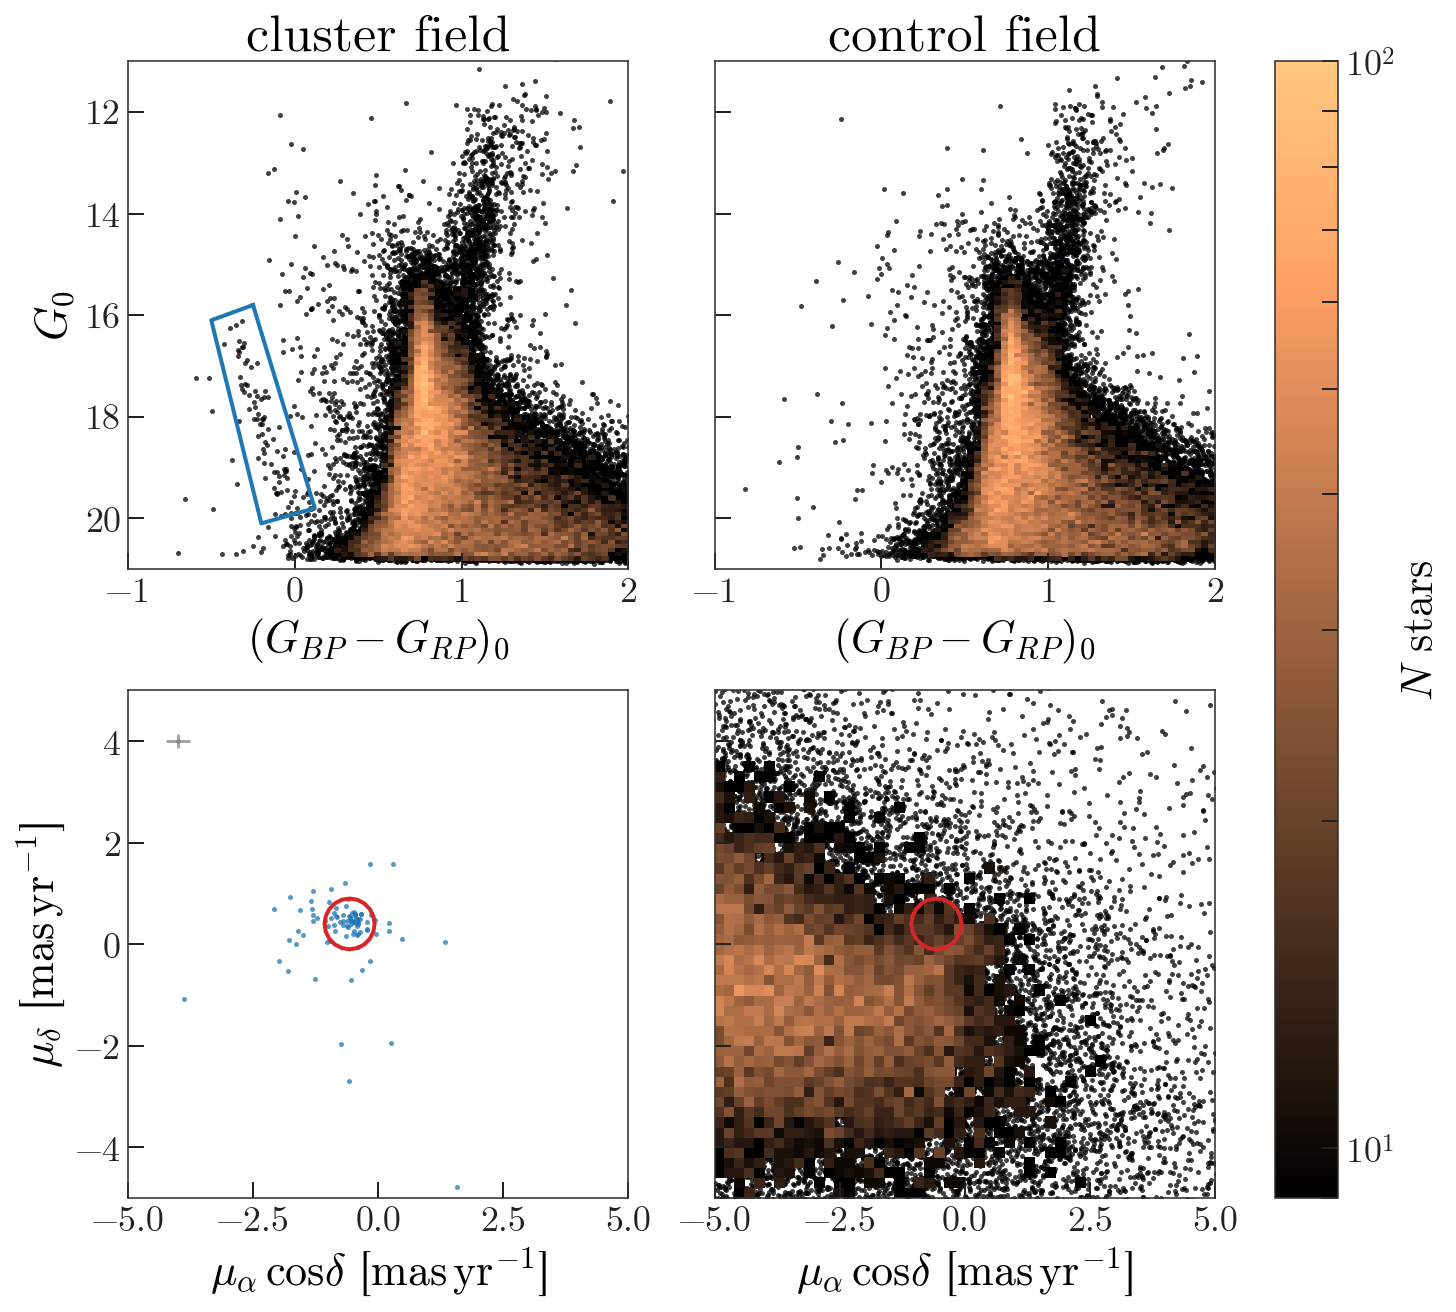

In [78]:
pt_thresh = 8
norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=1e2)

fig, all_axes = plt.subplots(2, 2, figsize=(10, 9), 
                             sharex='row', sharey='row', 
                             constrained_layout=True)

# ----
# CMD:

axes = all_axes[0]

ax = axes[0]
H_fg[H_fg < pt_thresh] = np.nan
ax.pcolormesh(xe_cmd, ye_cmd, H_fg, 
              norm=norm, **pcolor_style)
ax.plot(bprp0[cl_rough_mask], G0[cl_rough_mask], 
        zorder=-10, **dark_ptstyle)

nodes = np.array([[-0.25, 15.8],
                  [0.12, 19.8],
                  [-0.2, 20.1],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
ax.plot(nodes[:, 0], nodes[:, 1], marker='', color='tab:blue', lw=2)
cmd_path = mpl.patches.Path(nodes)

ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_ylabel('$G_0$')
ax.set_title('cluster field')

ax = axes[1]
H_bg[H_bg < pt_thresh] = np.nan
ax.pcolormesh(xe_cmd, ye_cmd, H_bg, 
              norm=norm, **pcolor_style)
ax.plot(bprp0[control_mask], G0[control_mask], 
        zorder=-10, **dark_ptstyle)
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_title('control field')

ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

# --------------
# Proper motion:

X = np.vstack((bprp0, G0)).T
poly_mask = cmd_path.contains_points(X)
poly_mask.sum()

axes = all_axes[1]

ax = axes[0]
style = dark_ptstyle.copy()
style['color'] = 'tab:blue'
ax.plot(g.pmra[cl_rough_mask & poly_mask], g.pmdec[cl_rough_mask & poly_mask], 
        zorder=-10, **style)

masyr = ' [{0:latex_inline}]'.format(u.mas/u.yr)
ax.set_xlabel(r'$\mu_\alpha \, \cos \delta$' + masyr)
ax.set_ylabel(r'$\mu_\delta$' + masyr)

ax = axes[1]
H_bg_pm[H_bg_pm < pt_thresh] = np.nan
cs = ax.pcolormesh(xe_pm, ye_pm, H_bg_pm, 
                   norm=norm, **pcolor_style)
ax.plot(g.pmra[control_mask], g.pmdec[control_mask], 
        zorder=-10, **dark_ptstyle)

ax.set_xlabel(r'$\mu_\alpha \, \cos \delta$' + masyr)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

for ax in axes:
    pm_circ = mpl.patches.CirclePolygon((-0.57, 0.4), radius=0.5, 
                                        edgecolor='tab:red', facecolor='none', 
                                        linewidth=2)
    ax.add_patch(pm_circ)

# Plot typical error
pm_mask = np.sqrt( (g.pmra.value-pm_circ.xy[0])**2 + (g.pmdec.value-pm_circ.xy[1])**2 ) < pm_circ.radius
pmra_err = np.nanmean(g.pmra_error[cl_rough_mask & poly_mask & pm_mask & (G0 < 19.3)].value)
pmdec_err = np.nanmean(g.pmdec_error[cl_rough_mask & poly_mask & pm_mask & (G0 < 19.3)].value)
axes[0].errorbar(-4, 4, 
                 xerr=pmra_err, yerr=pmdec_err, 
                 marker='.', ls='none', alpha=0.75, color='#888888')
cb = fig.colorbar(cs, ax=all_axes[:, 1])
cb.set_label('$N$ stars')

# fig.tight_layout()

fig.savefig('../plots/figures/gaia-cmd-pm.pdf', dpi=200)

In [90]:
pm_mask_on = np.sqrt( (g.pmra.value-pm_circ.xy[0])**2 + (g.pmdec.value-pm_circ.xy[1])**2 ) < 0.3
pm_mask_off = np.sqrt( (g.pmra.value- -1.25)**2 + (g.pmdec.value--0.5)**2 ) < 0.3

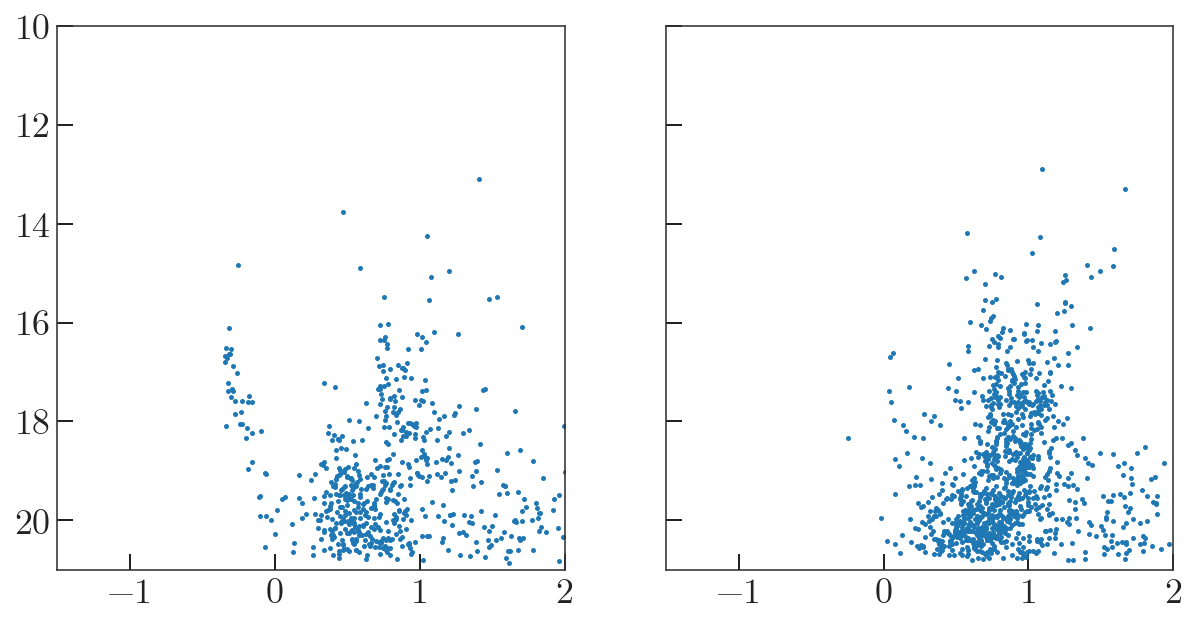

In [91]:
# H, xe, ye = np.histogram2d(bprp0[pm_mask], G0[pm_mask],
#                            bins=bins)
# H = H.T

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(bprp0[pm_mask_on], G0[pm_mask_on], marker='.', ls='none')
ax.set_xlim(-1.5, 2)
ax.set_ylim(21, 10)

ax = axes[1]
ax.plot(bprp0[pm_mask_off], G0[pm_mask_off], marker='.', ls='none')

---

# Rejected plots

In [ ]:
from astropy.convolution import convolve, Gaussian2DKernel

x_binsize = 0.05
y_binsize = 0.08

x_stddev = 0.06 / x_binsize # mag
y_stddev = 0.06 / y_binsize # mag

K = Gaussian2DKernel(x_stddev=x_stddev, y_stddev=y_stddev)

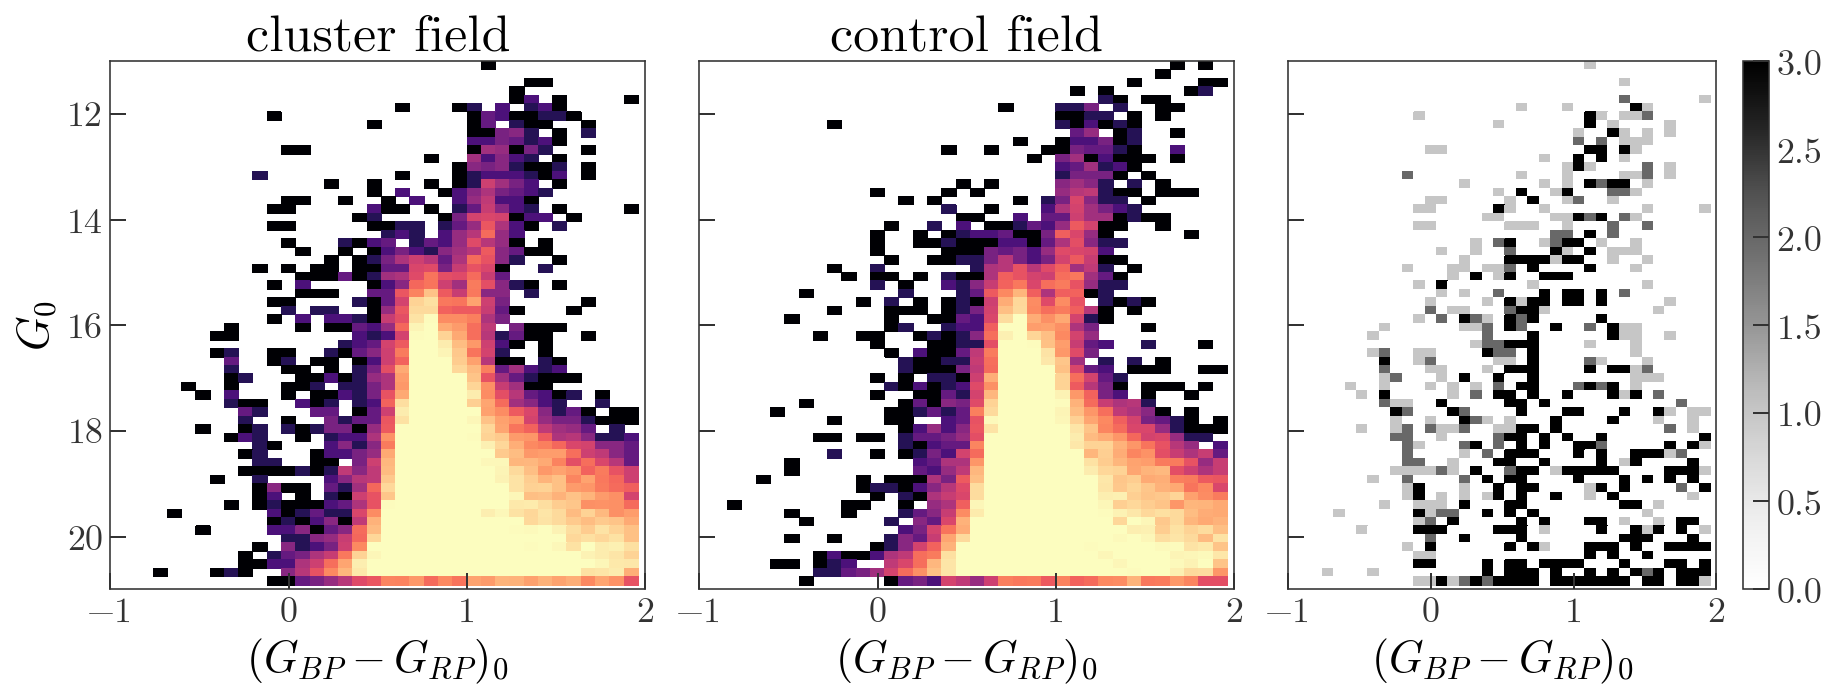

In [133]:
norm = mpl.colors.LogNorm(vmin=1e0, vmax=1e2)

fig, axes = plt.subplots(1, 3, figsize=(9+4, 5), sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(xe, ye, H_fg, 
              norm=norm, cmap='magma')
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_ylabel('$G_0$')
ax.set_title('cluster field')

ax = axes[1]
ax.pcolormesh(xe, ye, H_bg, 
              norm=norm, cmap='magma')
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_title('control field')

ax = axes[2]
cs = ax.pcolormesh(xe, ye, H_fg - H_bg, 
                   cmap='Greys', vmin=0, vmax=3)
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
# ax.set_title('control field')
fig.colorbar(cs)

ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

fig.tight_layout()

(21, 11)

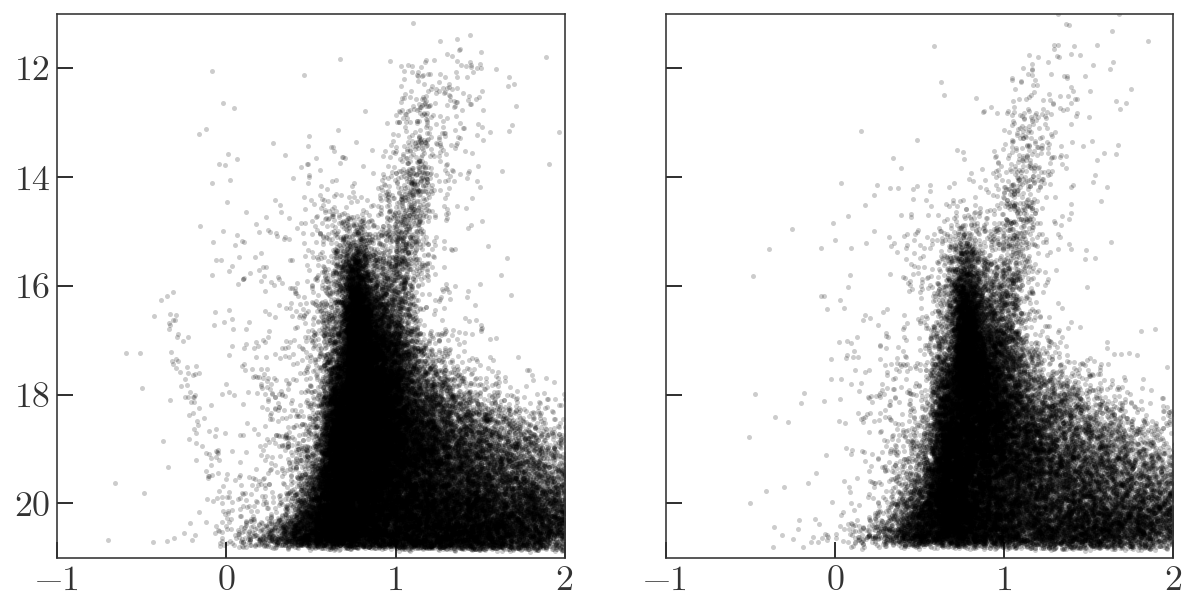

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(bprp0[cl_rough_mask], G0[cl_rough_mask], **ptstyle)

ax = axes[1]
ax.plot(bprp0[control_mask], G0[control_mask], **ptstyle)


# ax = axes[1]
# ax.plot(bprp0[~cl_rough_mask], G0[~cl_rough_mask], **ptstyle)


ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

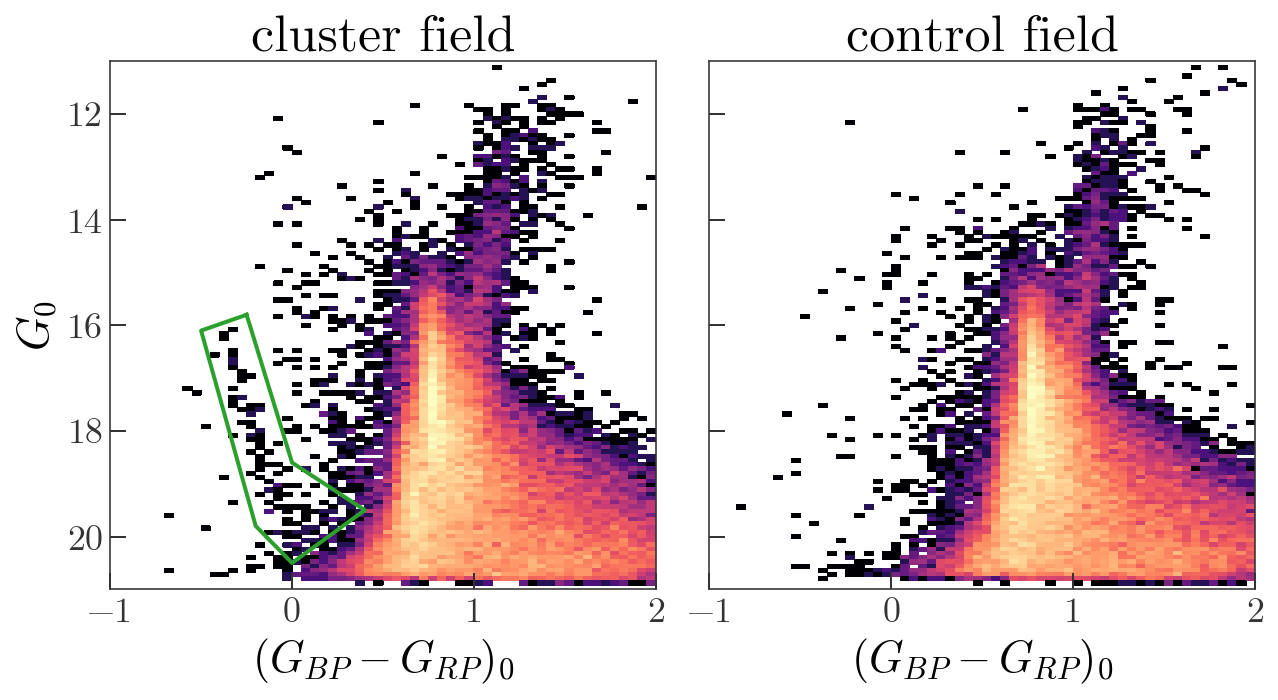

In [179]:
norm = mpl.colors.LogNorm(vmin=1e0, vmax=1e2)

fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(xe_cmd, ye_cmd, H_fg, 
              norm=norm, cmap='magma')

nodes = np.array([[-0.25, 15.8],
                  [0, 18.6],
                  [0.4, 19.5],
                  [0., 20.5],
                  [-0.2, 19.8],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
ax.plot(nodes[:, 0], nodes[:, 1], marker='', color='tab:green', lw=2)
cmd_path = mpl.patches.Path(nodes)

ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_ylabel('$G_0$')
ax.set_title('cluster field')

ax = axes[1]
ax.pcolormesh(xe_cmd, ye_cmd, H_bg, 
              norm=norm, cmap='magma')
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_title('control field')

ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

fig.tight_layout()